<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chunk-Model" data-toc-modified-id="Chunk-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chunk Model</a></span></li></ul></div>

In [2]:
# first, test generative model on one dimensional graphs
import sys
sys.path.append('../HCM')
from main import *
import seaborn as sns
import pandas as pd

## Chunk Model

In [3]:
# demonstrate the graph structure as the number of observation increases
import operator
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

plt.figure(figsize = (10,10))

def plot_chunk_graph(vertex_list, edges, location, ax=None, Print = False):
    chunks = []
    for ck in vertex_list:
        chunks.append(list(np.ravel(tuple_to_arr(ck)).astype(int)))
    if Print:
        print('chunks ', chunks)
        print('edges ', edges)
        print('location ', location)
    location[0] = [1,8]
    element_palette = {0:'#FFFFFF', 1:'#FFCAB1', 2:'#C1D7AE', 3:'#B10FBD',4:'#6C809A'}  # colorblind palette
    chunk_element_offset = {1: [0], 2: [-0.1, 0.1], 3: [-0.2, 0, 0.2], 4: [-0.3, -0.1, 0.1, 0.3],5:[-0.4, -0.2,0, 0.2, 0.4],6:[-0.6,-0.4, -0.2, 0, 0.2,0.4],7:[-0.6,-0.4, -0.2,0, 0.2, 0.4,0.6],8:[-0.8,-0.6,-0.4, -0.2,0,0.2, 0.4,0.6]}


    chunk_element_distance = 0.9
    if ax is None:
        f, ax = plt.subplots()

    chunks_by_length = defaultdict(list)
    for chunk in chunks:
        chunks_by_length[len(chunk)].append(chunk)
    max_width = max(len(v) for v in chunks_by_length.values())

    node_pos = {}
    for i in range(0,len(chunks)):
        chunk = chunks[i]
        chunk_id = chunks.index(chunk)
        chunk_len = len(chunks[chunk_id])
        n_on_level = len(chunks_by_length[chunk_len])
        id_on_level = chunks_by_length[chunk_len].index(chunk)
        xpos = location[i][0]
        ypos = location[i][1]
        node_pos[chunk_id] = (xpos, ypos)

    G = nx.MultiDiGraph()
    for node in range(len(chunks)):
        G.add_node(node, pos=node_pos[node])

    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=0)

    edge_color = ['k' if weight else 'grey' for weight in nx.get_edge_attributes(G,'weight').values()]

    nx.draw_networkx(G, node_pos,
                        node_color='grey',
                        node_size=0.0001,
                        #connectionstyle='arc3, rad = 0.1',
                        arrowsize=15,
                        width=3,
                        with_labels=False,
                        edge_color=edge_color,
                        alpha = 0.3,
                        ax=ax)

    for chunk_id, chunk in enumerate(chunks):

        for element_id, element in enumerate(chunk):
            ax.scatter([node_pos[chunk_id][0] + (chunk_element_offset[len(chunk)][element_id] * chunk_element_distance)],
                        [node_pos[chunk_id][1]],
                        c=element_palette[element % 5],
                        edgecolors = 'lightgrey',
                        linewidth=3,
                        marker='s',
                        s=600
                        #zorder=5
                        )
    plt.axis("off")
    plt.show()

    return ax

<Figure size 1000x1000 with 0 Axes>

# Experimental Data

In [4]:
tbl_e2 = pd.read_csv("../InputData/human_data/gershman-2018-e2.csv")
tbl_rb = pd.read_csv("../InputData/human_data/speekenbrink-konstantinidis-2015.csv")

In [5]:
tbl_e2_grouped = tbl_e2.groupby(tbl_e2["subject"])
e2_subjects = list(tbl_e2_grouped.groups.keys())

In [6]:
tbl_rb_grouped = tbl_rb.groupby("id")
rb_subjects = list(tbl_rb_grouped.groups.keys())

In [7]:
choices = tbl_e2_grouped.get_group(e2_subjects[0])["choice"]

Transitions between blocks have to be marked

Random samples of digits are used for that

In [8]:
tbl_design_e2 = tbl_e2[["subject", "block"]].value_counts().reset_index()[["subject", "block"]]
trials_unique = pd.Series(np.concatenate((tbl_e2["trial"].unique(), np.array([11]))), name = "trial")
tbl_design_e2 = tbl_design_e2.merge(trials_unique, how = "cross")

In [9]:
tbl_e2_extend = tbl_design_e2.merge(tbl_e2[["subject", "block", "trial", "choice"]], how = "left")

In [15]:
def get_chunks_one_participant(subj_idx, tbl_e2_extend):
    # fill block transitions with random integers
    choices = tbl_e2_extend["choice"][tbl_e2_extend["subject"] == subj_idx]
    choices[pd.isna(choices)] = np.round(np.random.normal(100, 20, 20))
    np_choices = choices.to_numpy().reshape(choices.shape[0], 1, 1)
    # model
    cggt = generative_model_random_combination(D=5, n=5)
    cggt = to_chunking_graph(cggt)
    learned_M, _, _, _ = partition_seq_hastily(np_choices, list(cggt.M.keys()))
    cg = Chunking_Graph(DT = 0, theta=1)
    cg = rational_chunking_all_info(np_choices, cg) 
    return cg.vertex_list

In [11]:
from functools import partial

In [12]:
f_partial = partial(get_chunks_one_participant, tbl_e2_extend = tbl_e2_extend)

In [13]:
iterable = map(f_partial, e2_subjects)
l_results_e2 = list(iterable)

NameError: name 'choices_s1' is not defined

In [33]:
choices_s1 = tbl_e2_extend["choice"][tbl_e2_extend["subject"] == 6]
choices_s1[pd.isna(choices_s1)] = 3
#choices_s1[pd.isna(choices_s1)] = np.round(np.random.normal(100, 20, 20))
np_choices_s1 = choices_s1.to_numpy().reshape(choices_s1.shape[0], 1, 1)

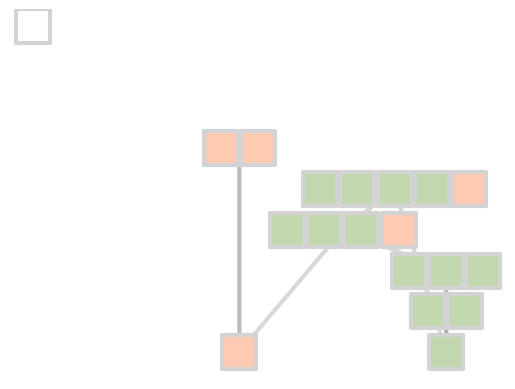

<AxesSubplot:>

In [34]:
cggt = generative_model_random_combination(D=5, n=3)
cggt = to_chunking_graph(cggt)
plot_chunk_graph(cggt.vertex_list,cggt.edge_list, cggt.vertex_location)

chunks  [[2], [1], [3], [1, 1], [2, 2], [2, 2, 2, 2], [1, 1, 1, 1], [2, 1]]
edges  [(1, 3), (1, 3), (0, 4), (0, 4), (4, 5), (4, 5), (3, 6), (3, 6), (0, 7), (1, 7)]
location  [[1, 0], [2, 0], [3, 0], [2.0, 1], [1.0, 2], [1.0, 3], [2.0, 4], [1.5, 5]]


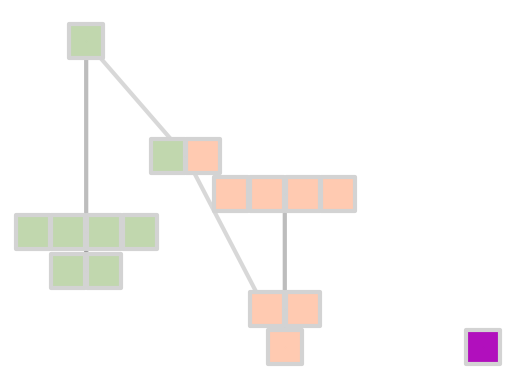

<AxesSubplot:>

In [35]:
learned_M, _, _,_ = partition_seq_hastily(np_choices_s1, list(cggt.M.keys()))
cg = Chunking_Graph(DT = 1, theta=0)
cg = rational_chunking_all_info(np_choices_s1, cg) 
plot_chunk_graph(cg.vertex_list,cg.edge_list, cg.vertex_location, Print=True)